In [0]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, f_regression, f_classif

from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import copy

In [0]:
SEED = 42

# Data Preprocessing 

In [27]:
import os
os.getcwd()

'/content'

In [0]:
# load training data

# load data from csv file

HOMEDIR = './drive/My Drive/IML Projects/task_2'
df_train_features = pd.read_csv(HOMEDIR + "/train_features.csv")
df_train_labels = pd.read_csv(HOMEDIR + '/train_labels.csv')

# Load test data
df_test_features = pd.read_csv(HOMEDIR + '/test_features.csv')

In [0]:
df_train_labels = df_train_labels.sort_values('pid')
df_train_features = df_train_features.sort_values(['pid','Time'])
df_test_features = df_test_features.sort_values(['pid','Time'])

# # Droping time
# df_train_features = df_train_features.drop('Time', axis = 1)
# df_test_features = df_test_features.drop('Time', axis = 1)

In [0]:
train_pids = df_train_features['pid'].unique()
test_pids = df_test_features['pid'].unique()

# Imputation and aggregation

### Training data

In [0]:
# can also use data.interpolate to do a linear interpolation of the missing values
df_train_patient = df_train_features.groupby(['pid'], as_index=False).apply(lambda group: group.interpolate(method = 'linear'))

In [32]:
len(train_pids)

18995

In [0]:
nancount = lambda x: x.isna().sum()
df_train_agg_features = df_train_patient.groupby('pid').agg([("mean", np.nanmean)
                                                            ,("std", np.nanstd), 
                                                             'last', 'first',
                                                             ("nancount", nancount)])

In [34]:
# Dropping time and age features
df_train_agg_features = df_train_agg_features.drop(df_train_agg_features.columns[[0,1,2,3,4,6,7,8,9]], axis = 1)
df_train_agg_features

Age EtCO2                 ...        pH                               
       mean  mean std last first  ...      mean       std  last first nancount
pid                               ...                                         
1      34.0   NaN NaN  NaN   NaN  ...  7.381667  0.027047  7.39  7.33      0.0
2      86.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
4      66.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
6      66.0   NaN NaN  NaN   NaN  ...  7.348182  0.017215  7.34  7.35      1.0
8      42.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
...     ...   ...  ..  ...   ...  ...       ...       ...   ...   ...      ...
31653  52.0   NaN NaN  NaN   NaN  ...  7.330000  0.000000  7.33  7.33      3.0
31654  66.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31656  44.0   NaN NaN  NaN   NaN  ...  7.311818  0.031644  7.33  7.25      1.0
31657  70.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31658  60.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0

[18995 rows x 171 columns]

In [35]:
imp_mean = IterativeImputer(random_state=SEED, skip_complete = True)
data_train_imputed = imp_mean.fit_transform(df_train_agg_features)
    data_train_imputed = pd.DataFrame(data_train_imputed, columns = df_train_agg_features.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [36]:
data_train_imputed

Age      EtCO2            ...        pH                   
       mean       mean       std  ...      last     first nancount
0      34.0  30.135866  2.033409  ...  7.390000  7.330000      0.0
1      86.0  33.204376  2.424561  ...  7.383466  7.376632     12.0
2      66.0  32.816170  2.382235  ...  7.382124  7.378224     12.0
3      66.0  32.539074  2.463477  ...  7.340000  7.350000      1.0
4      42.0  33.080760  2.618194  ...  7.382574  7.373168     12.0
...     ...        ...       ...  ...       ...       ...      ...
18990  52.0  30.055695  2.027981  ...  7.330000  7.330000      3.0
18991  66.0  32.877875  2.572902  ...  7.380438  7.371143     12.0
18992  44.0  32.850183  2.703938  ...  7.330000  7.250000      1.0
18993  70.0  33.070286  2.572954  ...  7.383966  7.370770     12.0
18994  60.0  32.268647  2.243530  ...  7.386553  7.371090     12.0

[18995 rows x 171 columns]

### Test data

In [0]:
# can also use data.interpolate to do a linear interpolation of the missing values
df_test_patient = df_test_features.groupby(['pid'], as_index=False).apply(lambda group: group.interpolate(method = 'linear'))

In [0]:
nancount = lambda x: x.isna().sum()
df_test_agg_features = df_test_patient.groupby('pid').agg([("mean", np.nanmean)
                                                            ,("std", np.nanstd), 
                                                             'last', 'first',
                                                             ("nancount", nancount)])

In [39]:
# Dropping time and age features
df_test_agg_features = df_test_agg_features.drop(df_train_agg_features.columns[[0,1,2,3,4,6,7,8,9]], axis = 1)
df_test_agg_features

Time                       ...        pH                     
      mean       std last first  ...       std  last first nancount
pid                              ...                               
0      6.5  3.605551   12     1  ...  0.022804  7.40  7.34      2.0
3      6.5  3.605551   12     1  ...       NaN   NaN   NaN     12.0
5      6.5  3.605551   12     1  ...       NaN   NaN   NaN     12.0
7      6.5  3.605551   12     1  ...  0.014880  7.36  7.40      4.0
9      6.5  3.605551   12     1  ...       NaN   NaN   NaN     12.0
...    ...       ...  ...   ...  ...       ...   ...   ...      ...
31647  6.5  3.605551   12     1  ...       NaN   NaN   NaN     12.0
31649  6.5  3.605551   12     1  ...  0.014118  7.30  7.26      1.0
31651  6.5  3.605551   12     1  ...  0.024307  7.38  7.41      1.0
31652  6.5  3.605551   12     1  ...       NaN   NaN   NaN     12.0
31655  6.5  3.605551   12     1  ...       NaN   NaN   NaN     12.0

[12664 rows x 171 columns]

In [40]:
imp_mean = IterativeImputer(random_state=SEED, skip_complete = True)
data_test_imputed = imp_mean.fit_transform(df_test_agg_features)
data_test_imputed = pd.DataFrame(data_test_imputed, columns = df_test_agg_features.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### Standardizing the data

In [0]:
standard_scalar = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = standard_scalar.fit_transform(data_train_imputed)
data_train_scaled = pd.DataFrame(data_train_scaled, columns = list(data_train_imputed))

data_test_scaled = standard_scalar.transform(data_test_imputed)
data_test_scaled = pd.DataFrame(data_test_scaled, columns = list(data_test_scaled))

In [42]:
df_train_agg_features

Age EtCO2                 ...        pH                               
       mean  mean std last first  ...      mean       std  last first nancount
pid                               ...                                         
1      34.0   NaN NaN  NaN   NaN  ...  7.381667  0.027047  7.39  7.33      0.0
2      86.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
4      66.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
6      66.0   NaN NaN  NaN   NaN  ...  7.348182  0.017215  7.34  7.35      1.0
8      42.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
...     ...   ...  ..  ...   ...  ...       ...       ...   ...   ...      ...
31653  52.0   NaN NaN  NaN   NaN  ...  7.330000  0.000000  7.33  7.33      3.0
31654  66.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31656  44.0   NaN NaN  NaN   NaN  ...  7.311818  0.031644  7.33  7.25      1.0
31657  70.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0
31658  60.0   NaN NaN  NaN   NaN  ...       NaN       NaN   NaN   NaN     12.0

[18995 rows x 171 columns]

In [0]:
pd.DataFrame(data_train_scaled).to_csv("./Results/dat_train_scaled.csv", index = False)
pd.DataFrame(data_test_scaled).to_csv("./Results/dat_test_scaled.csv", index = False)

# Kernelized ridge regression

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.1s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.8min finished


[0.83426281 0.84307314 0.87164621 0.89970894 0.91367457 0.91832753
 0.9193797  0.91997379 0.92017495]
[0.83387699 0.84272226 0.87096521 0.89779468 0.90938801 0.91149222
 0.91145096 0.91108393 0.91082241]
{'C': 5}
0.9114922175415844
ROC AUC for feature LABEL_BaseExcess  :  0.9180852461856749


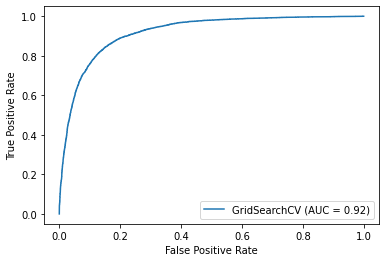

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.2min finished


[0.74836713 0.75379039 0.77313019 0.79842874 0.82292764 0.83405185
 0.8374622  0.83988714 0.84086855]
[0.74743669 0.7527503  0.77027276 0.78728012 0.79375036 0.78929474
 0.78684505 0.7847158  0.78356956]
{'C': 1}
0.7937503611989914
ROC AUC for feature LABEL_Fibrinogen  :  0.8217390695408598


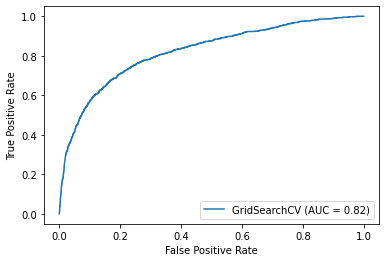

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.1min finished


[0.673596   0.67782666 0.69401991 0.71857161 0.7390063  0.74649738
 0.74827061 0.7493173  0.7496942 ]
[0.67291176 0.67702395 0.69223593 0.71327848 0.7249733  0.72449296
 0.72327743 0.72201058 0.72140324]
{'C': 1}
0.7249733027835424
ROC AUC for feature LABEL_AST  :  0.7386936173317341


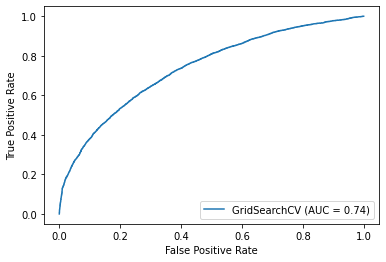

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.0min finished


[0.67678347 0.6815421  0.69885174 0.72292882 0.74308994 0.75015933
 0.75187832 0.75294691 0.7533311 ]
[0.67582872 0.68051369 0.69678593 0.71762852 0.72941348 0.72907144
 0.72799802 0.72699137 0.72646442]
{'C': 1}
0.7294134815856872
ROC AUC for feature LABEL_Alkalinephos  :  0.7427989669509976


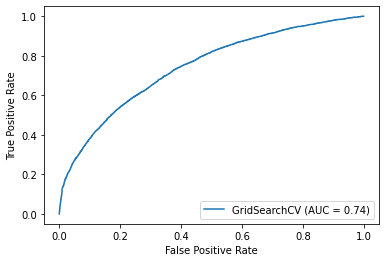

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.0min finished


[0.675891   0.6805089  0.69741398 0.72131547 0.74159623 0.74888635
 0.75066454 0.75175738 0.75215452]
[0.67524727 0.67970537 0.69569067 0.71585224 0.72736481 0.72707723
 0.72612861 0.72507848 0.72453072]
{'C': 1}
0.7273648126264387
ROC AUC for feature LABEL_Bilirubin_total  :  0.74126473990193


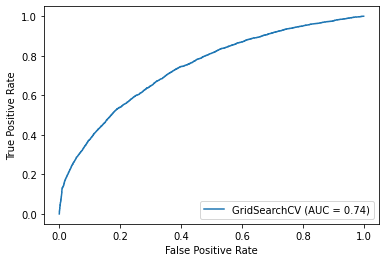

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.1min finished


[0.74470324 0.74868528 0.76295372 0.78133373 0.795181   0.80155815
 0.80324961 0.80435642 0.80476345]
[0.74427099 0.74814804 0.76148383 0.77674621 0.78335927 0.78301114
 0.78230974 0.78137769 0.78091975]
{'C': 1}
0.7833592672192081
ROC AUC for feature LABEL_Lactate  :  0.7949140128971653


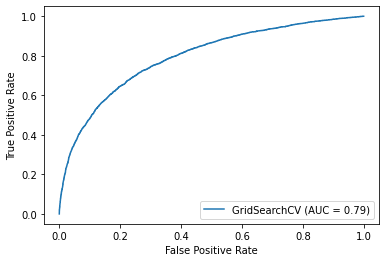

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.6min finished


[0.82756961 0.83392588 0.8540053  0.87105907 0.88684617 0.89521719
 0.89729492 0.89851215 0.8989202 ]
[0.82642494 0.83275563 0.85191898 0.86643915 0.87495612 0.87687491
 0.87651047 0.8756573  0.87507496]
{'C': 5}
0.8768749081931599
ROC AUC for feature LABEL_TroponinI  :  0.8945942693144471


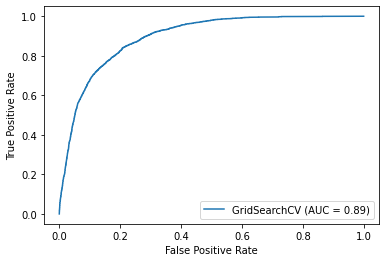

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.8min finished


[0.76637258 0.76998293 0.78410426 0.80532245 0.82107782 0.82698277
 0.82823003 0.82890092 0.82910496]
[0.76590407 0.7694032  0.78285041 0.80106404 0.81044106 0.81080739
 0.81011177 0.80930951 0.8088802 ]
{'C': 5}
0.8108073854648289
ROC AUC for feature LABEL_SaO2  :  0.8262776115498287


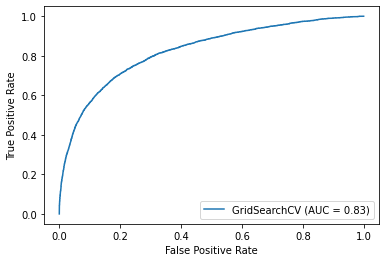

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  2.2min finished


[0.70110523 0.70598604 0.73055004 0.77173499 0.80950768 0.83114311
 0.83815091 0.84318772 0.84521835]
[0.6993799  0.70372114 0.72236942 0.74585242 0.74477734 0.73902294
 0.73671632 0.73441714 0.73287401]
{'C': 0.1}
0.7458524229638466
ROC AUC for feature LABEL_Bilirubin_direct  :  0.7715506474675504


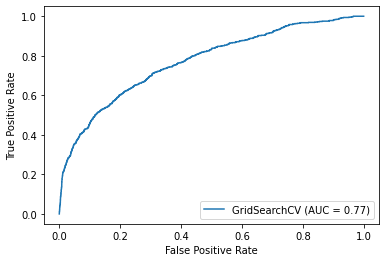

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.8min finished


[0.84215321 0.85481558 0.89807159 0.92554629 0.94003609 0.94565137
 0.94740685 0.94878464 0.94941416]
[0.84127409 0.85375617 0.89619923 0.92082489 0.92876211 0.92845401
 0.92760933 0.92653483 0.92586059]
{'C': 1}
0.9287621149731912
ROC AUC for feature LABEL_EtCO2  :  0.9397118668431921


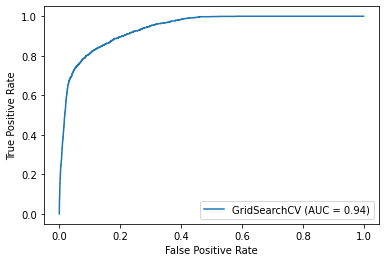

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.1s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.8min finished


[0.66644551 0.67478735 0.70455192 0.74101761 0.76923004 0.7812836
 0.78377176 0.7849667  0.78528608]
[0.66320671 0.67093898 0.6969591  0.72072336 0.72304971 0.71577172
 0.71151163 0.7078641  0.7061629 ]
{'C': 1}
0.7230497122530564
ROC AUC for feature LABEL_Sepsis  :  0.7672662411840261


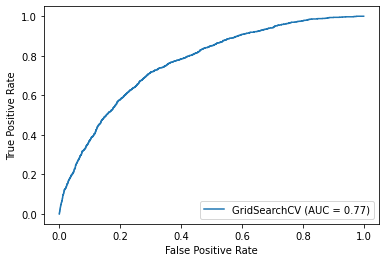

In [44]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import plot_roc_curve

for i in range(1, 12):
    #     feature selection
    transformer =  GenericUnivariateSelect(score_func= f_classif, mode ='k_best', param = 40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=300)
    
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)


    clf_w = LogisticRegression(penalty = 'l2', class_weight = 'balanced',
                                                               fit_intercept= True, max_iter=10000)
    
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'C':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    
    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1)
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = skf,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
#     print("Class weightt is ", clf_w.class_weight_)
 
    probability_tmp = clf.predict_proba(test_transformed)
    probability = [item[1] for item in probability_tmp]
    columns_1.append(probability)

    probability_tmp = clf.predict_proba(train_transformed)
    probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    
    svc_disp = plot_roc_curve(clf, train_transformed, df_train_labels.iloc[:,i])
    plt.show()

In [45]:
#labels that have a real value
from sklearn.metrics import make_scorer
columns_2 = []


for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= f_regression, mode ='k_best', param=40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print(data_train_scaled.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    if(i == 14):
        # Bagging the regressor have been tried, does not help
        clf_w = SVR(kernel = 'rbf', tol = 1e-4, cache_size= 7000)
        
        # This parameter vector have been tried, 1 is the best
        #parameters = {'base_estimator__C':(0.001, 0.01, 0.1, 1,10, 20)}
        #parameters = {'C':np.linspace(0.1,1,10)}
        parameters = {'C':(0.001, 0.01, 0.1, 0.5, 1,10)}
    else:
        clf_w = LinearSVR()
        parameters = {'C':(0.001, 0.001, 0.01, 0.1,1,10)}
        
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = make_scorer(r2_score), verbose = 2,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_features, df_train_labels.iloc[:,i])
        
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)



Index([            ('Age', 'mean'),       ('EtCO2', 'nancount'),
               ('Lactate', 'mean'),         ('Lactate', 'last'),
                  ('Temp', 'mean'),             ('Temp', 'std'),
                  ('Temp', 'last'),  ('BaseExcess', 'nancount'),
                 ('RRate', 'mean'),            ('RRate', 'std'),
                 ('RRate', 'last'),          ('RRate', 'first'),
             ('RRate', 'nancount'),             ('WBC', 'mean'),
                   ('WBC', 'last'),            ('WBC', 'first'),
                ('PaCO2', 'first'),       ('PaCO2', 'nancount'),
                  ('FiO2', 'last'),        ('FiO2', 'nancount'),
                  ('SaO2', 'mean'),             ('SaO2', 'std'),
                  ('SaO2', 'last'),           ('SaO2', 'first'),
              ('SaO2', 'nancount'),        ('ABPd', 'nancount'),
                  ('SpO2', 'mean'),             ('SpO2', 'std'),
                  ('SpO2', 'last'),           ('SpO2', 'first'),
              ('SpO2', 'n

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  1.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[-0.79769908 -0.79948187  0.40370704  0.419787    0.42033892  0.41437805]
[-0.80733218 -0.80944075  0.40147878  0.41693015  0.41719076  0.40794284]
{'C': 1}
0.4171907566300813
R2 for feature LABEL_RRate  :  0.42079490813288656
Index([                ('Age', 'mean'),             ('PTT', 'nancount'),
                       ('Temp', 'std'),                 ('Hgb', 'mean'),
                       ('Hgb', 'last'),                ('Hgb', 'first'),
                  ('HCO3', 'nancount'),      ('BaseExcess', 'nancount'),
                      ('PaCO2', 'std'),           ('PaCO2', 'nancount'),
                  ('FiO2', 'nancount'),                 ('SaO2', 'std'),
                     ('SaO2', 'first'),            ('SaO2', 'nancount'),
                      ('ABPm', 'mean'),                 ('ABPm', 'std'),
                      ('ABPm', 'last'),               ('ABPm', 'first'),
                  ('ABPm', 'nancount'),           ('Potassium', 'mean'),
                 ('Potassium', 'last'),    

[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   28.4s finished


[-26.34394096 -26.34394096   0.48202692   0.61696873   0.61963704
   0.61906982]
[-26.41478922 -26.41478922   0.47997661   0.61484087   0.61745194
   0.61679709]
{'C': 1}
0.6174519442547106
R2 for feature LABEL_ABPm  :  0.6197488420834469
Index([          ('Age', 'mean'),       ('Lactate', 'mean'),
             ('Lactate', 'last'),      ('Lactate', 'first'),
                 ('Hgb', 'mean'),           ('Hgb', 'last'),
                ('Hgb', 'first'),          ('HCO3', 'mean'),
                ('HCO3', 'last'),         ('HCO3', 'first'),
               ('RRate', 'mean'),         ('RRate', 'last'),
              ('RRate', 'first'),   ('Fibrinogen', 'first'),
       ('Phosphate', 'nancount'),         ('PaCO2', 'mean'),
               ('PaCO2', 'last'),        ('PaCO2', 'first'),
                ('FiO2', 'last'),      ('Platelets', 'std'),
                ('SaO2', 'mean'),          ('SaO2', 'last'),
               ('SaO2', 'first'),        ('Glucose', 'std'),
            ('Magnesium', 'st

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 41.1min finished


[0.06824719 0.2214748  0.2869852  0.34940573 0.39098223 0.61619776]
[0.07094293 0.22830856 0.28070442 0.30292598 0.30801848 0.29656793]
{'C': 1}
0.3080184841560339
R2 for feature LABEL_SpO2  :  0.39067019400313496
Index([           ('Age', 'mean'),         ('Lactate', 'std'),
          ('Lactate', 'nancount'),           ('Temp', 'mean'),
                  ('Temp', 'std'),           ('Temp', 'last'),
       ('BaseExcess', 'nancount'),          ('RRate', 'mean'),
                 ('RRate', 'std'),          ('RRate', 'last'),
               ('RRate', 'first'),            ('WBC', 'mean'),
                  ('WBC', 'last'),           ('WBC', 'first'),
            ('PaCO2', 'nancount'),       ('FiO2', 'nancount'),
             ('SaO2', 'nancount'),    ('Glucose', 'nancount'),
             ('Potassium', 'std'),  ('Potassium', 'nancount'),
                 ('ABPd', 'mean'),           ('ABPd', 'last'),
                ('ABPd', 'first'),        ('Calcium', 'mean'),
               ('Calcium', 'st

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:   59.3s finished


[-20.73661901 -20.73661901   0.54621925   0.66125989   0.66316235
   0.6630594 ]
[-20.78618208 -20.78618208   0.54439373   0.65976741   0.66145507
   0.66156564]
{'C': 10}
0.661565641269727
R2 for feature LABEL_Heartrate  :  0.6625706408240195


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
columns_final = columns_1 + columns_2

# Saving the results

In [47]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)
